In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


import pickle
import os
import h5py

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 2

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE

)

Found 16011 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
len(dataset)

501

In [7]:
for image_batch , label in dataset.take(1):
    print(image_batch.shape)
    print(label.numpy())

(32, 256, 256, 3)
[2 7 4 7 8 6 6 9 4 5 0 4 4 0 2 5 9 9 2 4 4 6 5 7 9 7 1 1 7 7 9 7]


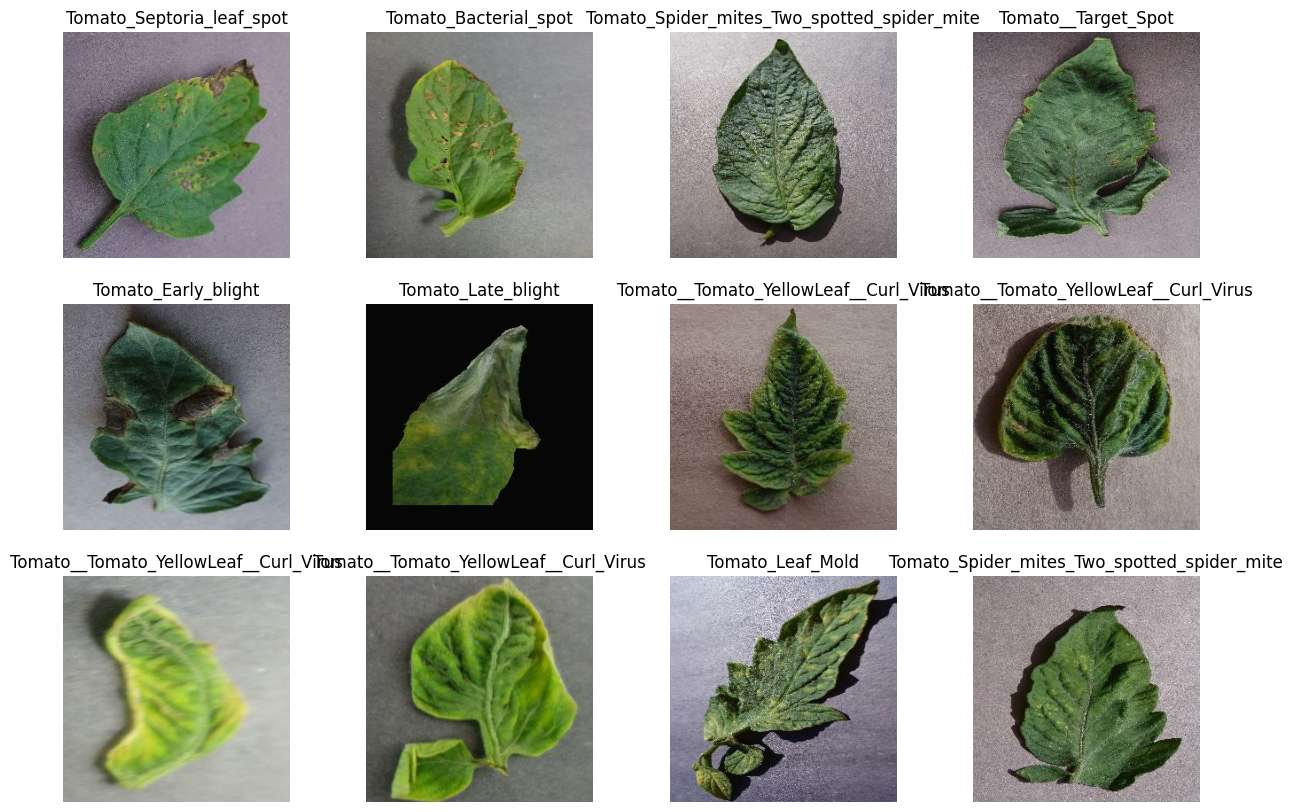

In [8]:
plt.figure(figsize=(15,10))
for image_batch , label in dataset.take(1):
    
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [9]:
len(dataset)

501

In [10]:
train_size = 0.8
len(dataset)* train_size

400.8

In [11]:
train_ds = dataset.take(400)
len(train_ds)

400

In [12]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [13]:
val_size = 0.1
len(dataset)* val_size

50.1

In [14]:
val_ds = test_ds.take(50)
len(val_ds)

50

In [15]:
test_ds = test_ds.skip(50)
len(test_ds)

51

In [16]:
def get_dataset_partitions(ds, train_split = 0.8, val_split= 0.1, test_split=0.1, shuffle = True , shuffle_size = 10000):
    
    
    ds_size = int(len(ds))
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        train_size = int(ds_size * train_split)
        val_size = int(ds_size * val_split)

        train_ds = ds.take(train_size)
        val_test_ds = ds.skip(train_size)

        val_ds = val_test_ds.take(val_size)
        test_ds = val_test_ds.skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions(ds = dataset)

In [18]:
len(train_ds), len(val_ds), len(test_ds)

(400, 50, 51)

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [20]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [21]:
resize_and_rescale_layer = tf.keras.Sequential([
    keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    keras.layers.Rescaling(1/255)
])

In [22]:
data_augmentation_layer = tf.keras.Sequential([
    keras.layers.RandomFlip('horizontal_and_vertical'),
    keras.layers.RandomRotation(0.4)
])

In [23]:
input_shape = (BATCH_SIZE ,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = keras.models.Sequential([
    resize_and_rescale_layer,
    data_augmentation_layer,
    
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape = input_shape, activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(class_names), activation='softmax')
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics = ['accuracy']
             )

In [26]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data= val_ds
)

Epoch 1/2
400/400 [==============================] - 95s 186ms/step - loss: 1.6002 - accuracy: 0.4393 - val_loss: 1.6436 - val_accuracy: 0.4919
Epoch 2/2
400/400 [==============================] - 53s 131ms/step - loss: 0.8484 - accuracy: 0.7005 - val_loss: 0.9914 - val_accuracy: 0.6669


In [27]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 26s 46ms/step - loss: 1.0035 - accuracy: 0.6654


In [26]:
# saving model
model_version = "test2-2-epochs"
#model.save(f"../saved_models/{model_version}/model")

In [27]:
#file_path = f"./models/pickle/{model_version}"

In [28]:
#os.makedirs("./models/pickle", exist_ok= True)

#with open(file_path, 'wb') as f:
#      pickle.dump(object, f)

In [29]:
#with open(file_path, 'rb') as f:
#      saved_model = pickle.load(f)

In [30]:
#model.save(f"../saved_models/{model_version}", save_format='h5')

In [31]:
#loaded_model = keras.models.load_model(f"../saved_models/{model_version}")
#loaded_model.summary()

In [32]:
model.evaluate(test_ds)


51/51 [==============================] - 22s 56ms/step - loss: 2.3070 - accuracy: 0.0788


[2.307035446166992, 0.07883302122354507]

In [35]:
tf.keras.models.save_model(model, f"{model_version}.keras")

In [36]:
tf.keras.models.save_model(model, f"./..//saved_models//{model_version}.keras")

In [33]:
loaded_model_2 = tf.keras.models.load_model(f"{model_version}.keras")
loaded_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [34]:
loaded_model_2.evaluate(test_ds)

51/51 [==============================] - 2s 29ms/step - loss: 1.0089 - accuracy: 0.6524


[1.0088804960250854, 0.6523898243904114]

In [35]:
loaded_model_2.predict(test_ds)

array([[2.39146601e-07, 1.04732011e-02, 1.11815601e-03, ...,
        4.15469020e-10, 3.87316468e-05, 9.38072860e-01],
       [3.69791836e-01, 4.77046728e-01, 9.65577271e-03, ...,
        7.95241371e-02, 1.49783345e-05, 2.25395706e-04],
       [7.81034459e-10, 2.22045276e-02, 4.73471810e-05, ...,
        8.55823884e-11, 4.65951343e-05, 2.08244517e-01],
       ...,
       [1.24273846e-11, 1.02281365e-05, 1.97912300e-06, ...,
        2.63126206e-16, 4.03399895e-07, 9.99263704e-01],
       [7.41147669e-05, 1.88650540e-03, 7.95549655e-04, ...,
        3.17502841e-02, 6.56060934e-01, 4.50872001e-04],
       [4.53951998e-06, 1.17013920e-02, 2.39526248e-03, ...,
        1.16699154e-03, 9.95944142e-02, 8.01288988e-04]], dtype=float32)

In [37]:
############ testing

In [48]:
import os
from PIL import Image

In [40]:
# D:\data_science\ml_projects\tomato_disease_prediction\training\data\Tomato_Early_blight

In [45]:
os.getcwd()

'D:\\data_science\\ml_projects\\tomato_disease_prediction\\training'

In [46]:
image_path = os.path.join(os.getcwd(), 'data', 'Tomato_Early_blight', '0d5f65a3-b32f-4565-b63a-c6da73c1322b___RS_Erly.B 8310.JPG' )

In [47]:
image_path

'D:\\data_science\\ml_projects\\tomato_disease_prediction\\training\\data\\Tomato_Early_blight\\0d5f65a3-b32f-4565-b63a-c6da73c1322b___RS_Erly.B 8310.JPG'

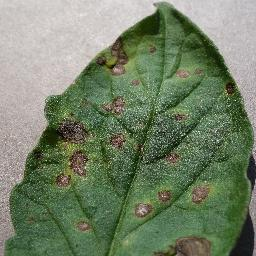

In [49]:
data = Image.open(image_path)
data

In [52]:
data_arr = np.array(data)
#data_arr

In [53]:
data_arr.shape

(256, 256, 3)

In [56]:
prediction = loaded_model_2.predict(np.expand_dims(data_arr, 0))

In [57]:
np.argmax(prediction)

6